# Real world use case of *fastText* and Tensorflow

## Based on Camptocamp.org community data, test different approaches to classification

*fastText* is a natural language processing (NLP) library released by Facebook Reasearch in 2017. Its main purpose is to create advanced language models and compute word embeddings. It also creates classifier models.

In [0]:
COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [0]:
!pip install fasttext tensorview

In [0]:
import fasttext # Do not use conda's version that is very old
import fasttext.util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import express as px, graph_objects as go
from sklearn import model_selection, preprocessing, metrics as skm
from tensorflow import keras
import tensorview as tv
import umap
from pathlib import Path
import json
import gc
import re

In [0]:
if COLAB:
  c2c_path = Path('/content/drive/My Drive/Colab Notebooks/C2C')
else:
  c2c_path = Path('.')

## Get the French language model

*fastText* provides model in 157 languages built from Common crawl and Wikipedia data.

"These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives"


In [0]:
from os import path
  
if COLAB:
  # Assume that the model is already downloaded to the Drive in .gz format
  if not path.exists("cc.fr.300.bin"):
    import gzip
    import shutil
    with gzip.open(c2c_path / 'data/cc.fr.300.bin.gz', 'rb') as f_in:
      with open('cc.fr.300.bin', 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
else:
  # Do this only once, will download 4+ GB of compressed model
  fasttext.util.download_model('fr')

In [0]:
ft = fasttext.load_model(str('cc.fr.300.bin'))

In this setup, there are as many labels as words in the vocabulary:

In [0]:
len(ft.words), len(ft.labels)

(2000000, 2000000)

## Similarities and neighbourood

Given a language model, *fastText* is able to provide the K nearest neighbors of a given word based on its embedding.

In [0]:
ft.get_nearest_neighbors('avalanche')

[(0.763619065284729, 'avalanches'),
 (0.6178566217422485, 'avalancheuse'),
 (0.617053210735321, 'avalancheux'),
 (0.5851721167564392, 'avalancheuses'),
 (0.5576048493385315, 'déferlante'),
 (0.5455480813980103, 'explosion'),
 (0.5397763252258301, 'paravalanche'),
 (0.5245974659919739, 'éboulement'),
 (0.5022478699684143, 'vague'),
 (0.4984055161476135, 'anti-avalanche')]

In [0]:
ft.get_nearest_neighbors('corde')

[(0.7247422933578491, 'cordes'),
 (0.6857317090034485, 'Corde'),
 (0.6725574731826782, 'corde.'),
 (0.6573895215988159, 'cordelette'),
 (0.6300966143608093, 'ficelle'),
 (0.6192356944084167, 'cordage'),
 (0.5814201831817627, 'sangle'),
 (0.5781804919242859, 'corder'),
 (0.558854341506958, 'filin'),
 (0.5542357563972473, 'poulie')]

In [0]:
ft.get_nearest_neighbors('coinceur')

[(0.7446964979171753, 'Coinceur'),
 (0.7404201626777649, 'coinceurs'),
 (0.5808221101760864, 'Coinceurs'),
 (0.5705815553665161, 'mouflage'),
 (0.5356436967849731, 'glissage'),
 (0.5311425924301147, 'descendeur'),
 (0.5081525444984436, 'desserage'),
 (0.5079815983772278, 'linguet'),
 (0.49019184708595276, 'tire-fort'),
 (0.48667481541633606, 'crabotage')]

In [0]:
ft.get_nearest_neighbors('Mont-Blanc')

[(0.7402255535125732, 'Mont-blanc'),
 (0.7172380089759827, 'Mt-Blanc'),
 (0.7107058167457581, 'Chamonix'),
 (0.6641087532043457, 'mont-Blanc'),
 (0.6392532587051392, 'Mont-Blan'),
 (0.6202214360237122, 'Léman'),
 (0.6038294434547424, 'Chamonix-Mont-Blanc'),
 (0.6020452976226807, 'Salève'),
 (0.6003657579421997, 'Cervin'),
 (0.6001231074333191, 'Mont-Cervin')]

In [0]:
"foehn" in ft.words, ft.get_nearest_neighbors("foehn")

(True,
 [(0.7486041188240051, 'fœhn'),
  (0.712364137172699, 'Foehn'),
  (0.6625443696975708, 'föhn'),
  (0.5280109643936157, 'mistral'),
  (0.5215004086494446, 'catabatique'),
  (0.5153074860572815, 'tramontane'),
  (0.4949257969856262, 'sirocco'),
  (0.4796677827835083, 'pluvio'),
  (0.4716402590274811, 'pluvieux'),
  (0.47065645456314087, 'redoux')])

### Analogies

Analogies are tri-partie extrapolation: given a relationship between two words (here the verb 'skier' and the sport or object 'ski'), give the corresponding words with similar distance for a third word (here 'vélo', bike)

In [0]:
ft.get_analogies("skier", "ski", "vélo")

[(0.6848655343055725, 'pédaler'),
 (0.6111614108085632, 'promener'),
 (0.6047613024711609, 'balader'),
 (0.6032814383506775, 'pédalant'),
 (0.5923284888267517, 'vélo.A'),
 (0.5899147987365723, 'vélo.'),
 (0.5815207362174988, 'Pédaler'),
 (0.5662391781806946, 'bicyclette'),
 (0.5573577880859375, 'vélo.-'),
 (0.5425165295600891, 'velo')]

# Inspect vocabulary's embeddings

## Mixed vocabulary

Let's first take a combination of vocabulary from mountaineering, biking, sailing.

In [0]:
voc_mountain1 = pd.DataFrame(set([
'ski', 'escalade', 'alpin', 'alpinisme', 'canyoning', 'parapente', 
 'altitude', 'arête', 'baton', 
 'chamois', 'cime', 'carre', 'corde', 'courbes de niveau',
 'denivelé', 
 'falaise', 'foehn',
 'marmotte', 'névé',
 'piolet', 'randonnée', 'refuge', 'sommet', 
 'télécabine', 'téléphérique', 'télésiège', 'trekking']), columns=['word'])
voc_mountain1['category'] = 'mountain'

voc_sailing = pd.DataFrame(set([
    'accastillage', 'affaler', 'allure', 'babord', 'bordée', 'brise', 
    'catamaran', 'croisière', 'dériveur', 'foils', 'foque', 'gréement',
    'marine', 'mat', 'monocoque', 
    'plaisance', 'proue', 'quille', 
    'régate', 'ressac',
    'tirant', 'tribord', 
    'voile', 'winch',
]), columns=['word'])
voc_sailing['category'] = 'sailing'

voc_biking = pd.DataFrame(set([
    'balade', 'braquet', 'danseuse', 'dérailleur',
    'guidon', 'frein',
    'peloton', 'pneu', 'poignée', 
    'rayon', 'roue', 
    'vélo', 'vtt',
]), columns=['word'])
voc_biking['category'] = 'biking'

voc_mixed = pd.DataFrame(set([
    'aiguille', 'cadre', 'carte', 'noeud', 'descente', 'topo-guide', 'vitesse',
]), columns=['word'])

voc_mixed['category'] = 'mixed'


voc1 = pd.concat([voc_mountain1, voc_sailing, voc_biking, voc_mixed])
voc1.shape

(71, 2)

Get the Fastext embeddings

In [0]:
voc_embeddings = np.array([ft.get_word_vector(w) for w in voc1['word']])
voc_embeddings.shape

(71, 300)

UMAP is reducing the dimensions from 300 to 2

In [0]:
reducer = umap.UMAP()
reduced_embeddings = reducer.fit_transform(voc_embeddings);
reduced_embeddings.shape

(71, 2)

In [0]:
fig = px.scatter(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], 
                 text=voc1['word'], color=voc1['category'],
                width=800, height=800)
fig.update_traces(textposition='top center', hovertext='ss')
fig.update_layout(title_text='Embeddings of the mixed mountaineering, biking & sailing vocabulary projected by UMAP in 2D')

Projected embedding are quite well gathered by sport. There are a few inconsistencies like the words 'danseuse' (dancer, upright on my bike) and 'rayon' (spoke) which are quite common words with many meanings (rayon also means ray as in sun ray). 'carte' (map) which is the most shared word in this vocabulary is right in the middle.

## Moutaineering vocabulary 

Let's take the vocabulary specific to the mountaineering activities and display the embeddings to verify if the words are correctly associated, i.e. the distance between them corresponds to the relatedness.

However, it is not possible to display the 300 dimension embeddings. Dimension reduction is necessary first. We could use PCA but it is focusing on the largest variance between samples and tend to gather items in spherical balls. That's why we will use more advanced UMAP that is better at projecting the relative distance between elements.

Vocabulary is a mix of mountaineering sports (alpinism, climbing, skiing...), mountain environment animals, topography and equipments.

Some are mountaineering only vocabulary, some are commonly used but get a special meaning in the context. For example, 'gendarme' means a policeman, but in the context of alpinism topo-guides it means a spike on a ridge that looks like a seating policeman. 

Some words are build of combination of words. That's not a full issue as FastText is able to extract meaning using character Ngrams.


In [0]:
voc_mountain2 = pd.DataFrame(set([
'ski', 'ski-randonnée', 'escalade', 'alpin', 'alpinisme', 'canyoning', 'parapente', 
 'altitude', 'aiguille', 'anneaux', 'arête', 'arquée', 'assureur',
 'baton', 'becquet', 'bivouac', 'bédière', 'bloc', 'boîte aux lettres', 'bouquetin', 'bombé', 'BRA',
 'CAF', 'caisson-hyperbare', 'chamois', 'chausson', 'cime', 'coinceur', 'coincement', 'combe', 
 'corde', 'cordée', 'cordelette', 'crampon', 'croupe', 'cuvette',
 'calcaire', 'carre', 'cirque', 'clapier', 'colonnette', 'cotation', 'couloir', 'coulée', 'courbes de niveau',
 'denivelé', 'dégel', 'descendeur', 'doline', 'dry-tooling', 'DVA',
 'éboulement', 'engagement', 'épaule', 'éperon', 'écaille', 'exposition',
 'falaise', 'FFME', 'fissure', 'foehn', 'foehn', 'friend',
 'gaz', 'gendarme', 'gneiss', 'goulotte', "gouttes d'eau",  'GPS', 'granite', 'grande voie', 'grimpe', 'grosses', 
 'hypothermie', 'hypoxie', 'hélitreuillage',
 'IGN', 'inclinaison', 'isard',
 'jumar',
 'lapiaz', 'lunule',
 'main-courante', 'mal des montagnes', 'mam', 'marmotte', 'mixte', 'mur', 'mouflage', 'mou',
 'névé',
 'oedème', 'orogénèse', 'ouvala',
 'peaux de phoque', 'pente', 'pelle', 'piolet', 'pic', 'pince', 'pierrier', 'plaque à vent', 'plat', 'pont de neige', 'poulie',
'queue de vache',
 'ramonage', 'randonnée', 'rappel', 'reculée', 'refuge', 'résurgence', 'rimaye', 'risque', 
 'sangle', 'sherpa', 'sécurité', 'sec', 'sommet', 'sonde',
 'table glaciaire', 'talveg', 'télécabine', 'telemark', 'téléphérique', 'télésiège', "tête d'alouette", 'topo-guide', 'trekking', 
 'urgence',
 'varappe', 'variante', 'verrou']), columns=['word'])

In [0]:
voc_mountain2['in_ft_voc'] = voc_mountain2['word'].apply(lambda w: w in ft.words)
print('Vocabulary contains %d words, among those %d are known to the downloaded French model' %(len(voc_mountain2), (voc_mountain2['in_ft_voc'] == True).sum()))

Vocabulary contains 132 words, among those 116 are known to the downloaded French model


Let's compute the embeddings for each words of the vocabulary

In [0]:
voc_embeddings = np.array([ft.get_word_vector(w) for w in voc_mountain2['word']])
voc_embeddings.shape

(132, 300)

UMAP is reducing the dimensions from 300 to 2

In [0]:
reducer = umap.UMAP()
reduced_embeddings = reducer.fit_transform(voc_embeddings);
reduced_embeddings.shape

(132, 2)

In [0]:
fig = px.scatter(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], 
                 text=voc_mountain2['word'], # color=voc_mountain2['in_ft_voc'],
                width=800, height=800)
fig.update_traces(textposition='top center', hovertext='ss')
fig.update_layout(title_text='Embeddings of the mountaineering vocabulary projected by UMAP in 2D', width=1000, height=800)

Some structures are found by the UMAP, like the connection between the sport disciplines and the FFME federation, or the link between the different cable cars (télésiège, télécabine, téléphérique). But there are clearly some lack of structure on the overall and some very specific vocabulary related to each discipline is spread all around (e.g.: climbing expressions for rock shapes: colonnette, arquée, pince, lunule, ramonage)

More specific training is required on a corpus that is dealing with mountaineering and climbing. For this we will use the Wikipedia of mountaineerers in western Europe: [camptocamp.org](http://www.camptocamp.org) and its [API](https://github.com/c2corg/v6_api).

Idealy we would only perform some kind of transfer learning, that is add some training to the existing language model. Advantages are big as we would keep the large and well trained French model. However, this does not seems possible so far with FastText, according to this [open issue](https://github.com/facebookresearch/fastText/issues/330)

# Supervized classification

Let's take a series of mountain routes loaded from CampToCamp.org, cleanup and tokenized in Notebook [DownloadC2cRoutes.ipynb](DownloadC2cRoutes.ipynb)

In [0]:
perf_summary = pd.DataFrame(columns=['model', 'metric', 'value'])
topn = 3
gc.collect()

59254

## Solution 1: Fasttext embeddings from French model + Tensorflow CNN

The embeddings of dimension 300 are computed using the French model here above.

These embeddings are then  fed into a convolutional deep neural network (CNN) to perform supervized classification versus the true activity labels.

In [0]:
seq_max_length = 300 # 100 words fully fits 30% of sequences, 300 words fits 80% of the sequences, 300 is limit for Colab's RAM
embedding_dim  = 300 # embedding dimension using the language model loaded above

description_tokens = pd.read_parquet(c2c_path / 'data/routes_description_tokens_all.parquet')
xall = keras.preprocessing.sequence.pad_sequences(description_tokens['description'].apply(json.loads), seq_max_length,
                                                  dtype=object, padding='post', truncating='post', value='')
del description_tokens
gc.collect()
xall.shape

(13464, 300)

In [0]:
xall = np.expand_dims(np.array([[ft.get_word_vector(str(x)) for x in row] for row in xall]), axis=3)
del ft
gc.collect()
xall.shape

(13464, 300, 300, 1)

In [0]:
routes = pd.read_parquet(c2c_path / 'data/routes_details_all_1hot.parquet')
routes.shape

(13464, 21)

In [0]:
activity_labels = ['hiking', 'ice_climbing', 'mountain_biking', 'mountain_climbing',
       'rock_climbing', 'skitouring', 'slacklining', 'snow_ice_mixed',
       'snowshoeing', 'via_ferrata']
act_label_array = np.array(activity_labels)
yall = routes[activity_labels].values

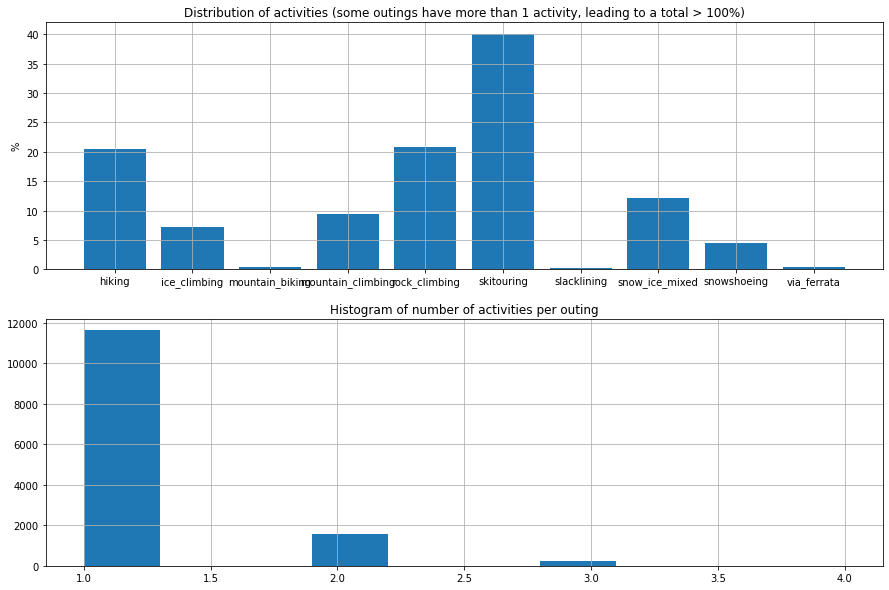

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes[0]
ax.bar(activity_labels, yall.mean(axis=0) * 100)
ax.set_title('Distribution of activities (some outings have more than 1 activity, leading to a total > 100%)')
ax.set_ylabel('%')
ax.grid()
ax = axes[1]
ax.hist(yall.sum(axis=1))
ax.set_title('Histogram of number of activities per outing')
ax.grid()

The distribution of the 10 activities is far from uniform. The *ski-randonnée* (ski touring) class is taking 40% of the samples, a few others are in the 20% range, and some close to 0.

It is clearly an issue when designing a classifier. The model will shift toward predicting the main class in order to reduce the error rate.

Most of the routes have only 1 label associated, the maximum number of labels is 3.

### Sol 1 - prepare data (scaling and split)

In [0]:
scaler = preprocessing.StandardScaler()
xshape = xall.shape
xall = scaler.fit_transform(xall.reshape(len(xall), -1)).reshape(xshape)

In [0]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(xall, yall, test_size=0.2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((10771, 300, 300, 1), (2693, 300, 300, 1), (10771, 10), (2693, 10))

### Sol 1 - classifier definition and training

In [0]:
model1 = keras.models.Sequential([
    keras.layers.Dropout(0.1, input_shape=(seq_max_length, embedding_dim, 1)),
    keras.layers.Convolution2D(8, kernel_size=(32, 32), activation='relu', strides=(2, 2), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Convolution2D(8, kernel_size=(8, 8), activation='relu', strides=(4, 4), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Convolution2D(16, kernel_size=(4, 4), activation='relu', strides=(4, 4), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(yall.shape[1], activation='sigmoid') # not softmax !
], name='model1')

model1.compile(optimizer=keras.optimizers.Adam(), #learning_rate=0.001), 
               loss=keras.losses.CategoricalCrossentropy(from_logits=False), 
               metrics=[keras.metrics.CategoricalAccuracy()])

model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 8)       8200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 8)         4104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 16)        0    

In [0]:
gc.collect()

15

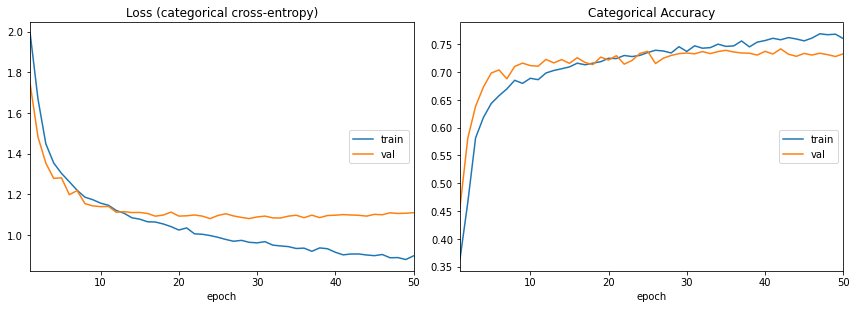

In [0]:
n_epochs = 50
batch_size = 64

callbacks = [
      #keras.callbacks.ModelCheckpoint(filepath= str(c2c_path / 'checkpoints/model_{epoch}'), save_best_only=True, verbose=1),
      tv.train.PlotMetricsOnEpoch(metrics_name=['Loss (categorical cross-entropy)', 'Categorical Accuracy'], cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
 ]

hist1 = model1.fit(xtrain, ytrain, epochs=n_epochs, validation_data=(xtest, ytest), verbose=1, callbacks=callbacks, batch_size=batch_size)

Convergence is two steps, initialy around 35% of accuracy, probably when the main class (ski touring) is fitted, then growing fast to 60% accuracy.

However, overfitting is quite fast and is visible on both the loss and the accuracy.

### Sol 1 - test the CNN classifier

In [0]:
ytest_est = model1.predict(xtest)

Given the multi-label classification with up to three labels per sample, let's compute the top-1, top-2 and top-3 accuracies : 
- top-1 is the regular accuracy but with applied to a samples with multiple labels: is the predicted class with highest probability among the labels  ?
- top-2 and top-3 performs the same but with the 2 and 3 hightest predicted probabilities and still attempting to the 1 to 3 labels of each samples.

In [0]:
ytest_accuracy_top, ytest_est_top = [], []
for i in range(1, topn+1):
  est_top = np.argpartition(ytest_est, -i, axis=1)[:, -i:]
  ytest_est_top.append(est_top)
  perf = ytest[range(len(ytest)), est_top.T].T.sum(axis=1) / np.minimum(np.ones(len(ytest)) * i, ytest.sum(axis=1))
  ytest_accuracy_top.append(perf)
  perf_summary = perf_summary.append({'model': 'model1', 'metric': 'top%d'% i, 'value': perf.mean()}, ignore_index=True)
  
perf_summary.loc[perf_summary.model == 'model1', ['metric', 'value']].set_index('metric')

,value
metric,
top1,0.778314
top2,0.898440
top3,0.946095


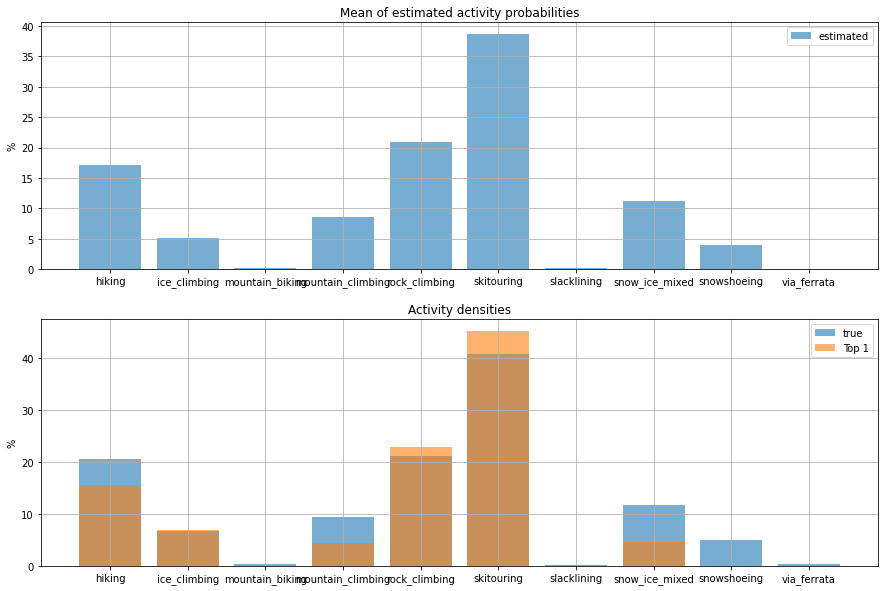

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes[0]
ax.bar(activity_labels, ytest_est.sum(axis=0) / len(ytest) * 100, label='estimated', alpha=0.6)
ax.set_title('Mean of estimated activity probabilities')
ax.set_ylabel('%')
ax.legend()
ax.grid()
ax = axes[1]
ax.bar(activity_labels, ytest.sum(axis=0) / len(ytest) * 100, label='true', alpha=0.6)
ax.bar(activity_labels, np.array([(ytest_est_top[0] == i).sum() for i in range(10)])/ len(ytest) * 100, label='Top 1', alpha=0.6)
ax.set_title('Activity densities')
ax.set_ylabel('%')
ax.legend()
ax.grid()

The prediction on the top 2 classes is good. On the smaller categories the result is not as good. 

Rock climbing is probably shadowing the variants that are ice, mountain and mixed (snow and ice) climbing.

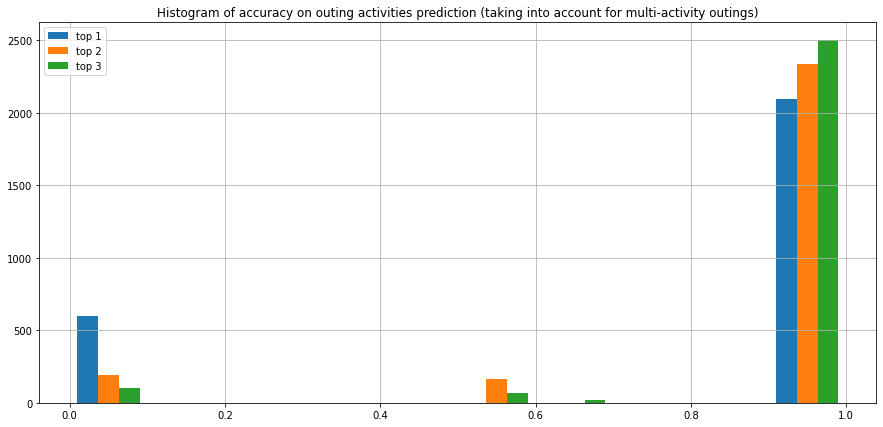

In [0]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(ytest_accuracy_top, density=False, label=['top %d' % i for i in range(1, topn+1)])
ax.legend()
ax.set_title('Histogram of accuracy on outing activities prediction (taking into account for multi-activity outings)')
ax.grid()

Wider models taking into account for longer sequences, up to 500 words were also tested, mean top-1, top-3 accuracy would increase a few percents.

In [0]:
gc.collect()

15

## Solution 2: build a classifier using *fastText* and the specific corpus

### Sol 2 - Prepare the corpus with labels for *fastText*

The model is based on the cleaned texts prefixed by the labels, themselves prefixed by '\_\_label\_\_'

In [0]:
def clean_text(text):
  return re.sub(r'[;,\.!\?\(\)]', ' ', text).replace('\n', ' ').replace('[\s+]', ' ')

def append_labels(rec):
  parts = []
  if rec['activities'] is not None:
    for label in json.loads(rec['activities']):
      parts.append('__label__' + label)
  parts.append(clean_text(rec['description_fr']))
  return ' '.join(parts)

xall = routes.apply(append_labels, axis=1).values
xall_ft_raw = routes['description_fr'].apply(clean_text).values

In [0]:
xtrain, xtest, xtrain_ft_raw, xtest_ft_raw, ytrain, ytest = model_selection.train_test_split(xall, xall_ft_raw, yall,
                                                                                             test_size=0.2)
xtrain.shape, xtest.shape, xtrain_ft_raw.shape, ytrain.shape

((10771,), (2693,), (10771,), (10771, 10))

*fastText* reads training and test samples from file only: let's write them to file

In [0]:
with open(c2c_path / 'data/c2c_train.txt', 'w') as f:
  f.writelines(rec + '\n' for rec in xtrain)

with open(c2c_path / 'data/c2c_test.txt', 'w') as f:
  f.writelines(rec + '\n' for rec in xtest)

### Sol 2 - fit of the *fastText* model

In [0]:
model2 = fasttext.train_supervised(str(c2c_path / 'data/c2c_train.txt'), epoch=64)
print(model2.labels)

['__label__skitouring', '__label__rock_climbing', '__label__hiking', '__label__snow_ice_mixed', '__label__mountain_climbing', '__label__ice_climbing', '__label__snowshoeing', '__label__mountain_biking', '__label__via_ferrata', '__label__slacklining']


### Sol 2 - test

In [0]:
n_sample, precision, recall = model2.test(str(c2c_path / 'data/c2c_test.txt'), k=3)
print('fastText classifier, vocabulary size=%d, number of labels=%d' % (len(model2.words), len(model2.labels)))
print(' performance on %d samples: precision=%.4g%%, recall=%.4g%%' % (n_sample, precision*100, recall*100))

fastText classifier, vocabulary size=50206, number of labels=10
 performance on 2693 samples: precision=37.65%, recall=97.13%


The accuracy reported bx the *fastText* test method is quite low but does not correspond to neither the CategoricalAccuracy of Keras nor the top-1 accuracy computed earlier. Let's recompute the top-1, top-2 and top-3 on the *fastText" predictions.

Example of test:

In [0]:
sel = 23
print('Prediction:', model2.predict(xtest_ft_raw[sel], k=3))
print('Actual:', xtest[sel])

Prediction: (('__label__rock_climbing', '__label__mountain_climbing', '__label__ice_climbing'), array([9.99982953e-01, 3.49391084e-05, 1.16517185e-05]))
Actual: __label__rock_climbing Approche   Depuis le parking  prendre le sentier qui part en direction du SE depuis l'épingle à cheveux  Le quitter rapidement pour prendre une sente à gauche qui mène à la grotte  marches et câbles   Traverser la grotte vers la gauche puis  lorsqu'on arrive au bord de la falaise  prendre une main courante qui amène au départ de la voie    Voie         L 1   6c+   Vertical sur gouttes d'eau  avec un crux bien marqué        L 2   5c         L 3   6b+   Départ bloc        L 4   7a+   Dans un dièdre ouvert de très beaux passages  superbe longueur  Patiné        L 5   7a   Belle longueur sur petites prises        L 6   6b+   En traversée sur la gauche  Un peu poussiéreuse        L 7   6b        


##### Top accuracies

In [0]:
topn = 3
label_args = {'__label__hiking': 0, '__label__ice_climbing': 1, '__label__mountain_biking': 2, '__label__mountain_climbing': 3,
       '__label__rock_climbing': 4, '__label__skitouring': 5, '__label__slacklining': 6, '__label__snow_ice_mixed': 7,
       '__label__snowshoeing': 8, '__label__via_ferrata': 9}
ytest_accuracy_top, ytest_est_top = [], []
predictions = [model2.predict(sample, k=topn) for sample in xtest_ft_raw]
for i in range(1, topn+1):
  est_top = np.array([[label_args[label] for label in pred[0][:i]] for pred in predictions])
  ytest_est_top.append(est_top)
  perf = ytest[range(len(ytest)), est_top.T].T.sum(axis=1) / np.minimum(np.ones(len(ytest)) * i, ytest.sum(axis=1))
  ytest_accuracy_top.append(perf)
  perf_summary = perf_summary.append({'model': 'model2', 'metric': 'top%d'% i, 'value': perf.mean()}, ignore_index=True)

perf_summary.loc[perf_summary.model == 'model2', ['metric', 'value']].set_index('metric')

,value
metric,
top1,0.911623
top2,0.954697
top3,0.978772


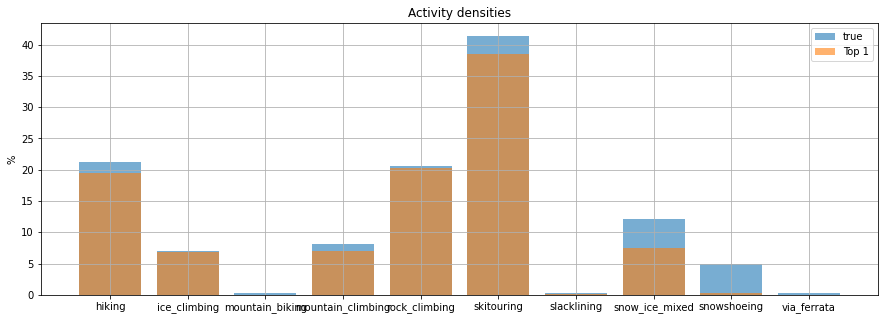

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#ax = axes[1]
ax.bar(activity_labels, ytest.sum(axis=0) / len(ytest) * 100, label='true', alpha=0.6)
ax.bar(activity_labels, np.array([(ytest_est_top[0] == i).sum() for i in range(10)])/ len(ytest) * 100, label='Top 1', alpha=0.6)
ax.set_title('Activity densities')
ax.set_ylabel('%')
ax.legend()
ax.grid()

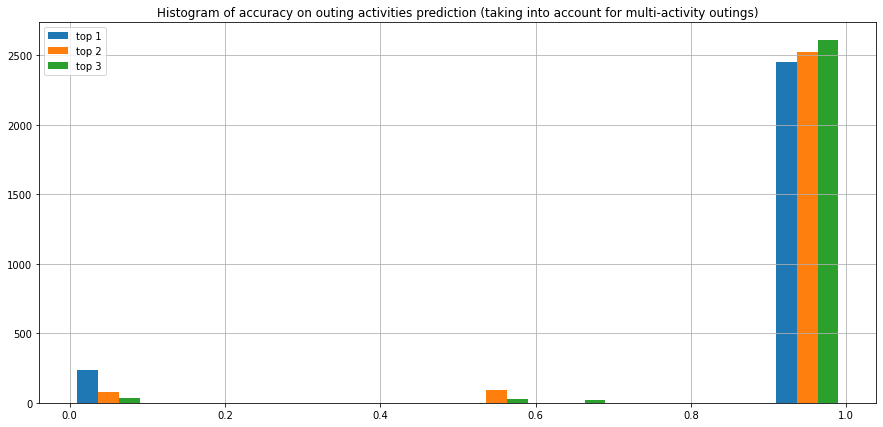

In [0]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(ytest_accuracy_top, density=False, label=['top %d' % i for i in range(1, topn+1)])
ax.legend()
ax.set_title('Histogram of accuracy on outing activities prediction (taking into account for multi-activity outings)')
ax.grid()

### Sol 2 - Conclusion on *fastText* classifier

With a  vocabulary of only 21188, that is 100 times smaller than the one of the full French model, with a very fast fitting from the corpus, the FastText classifier is reaching very high top-1 accuracy. It is not overfitting on the major class (ski touring). It is only failing on the very small classes (mountain biking, slacklining and viaferrata)

## Solution 3: specific *fastText* language model as input to the CNN classifier

Instead of using the large and not specific French model, let's fit a French model on our corpus. Then use this model to feed the CNN with embeddings.

In [0]:
with open(c2c_path / 'data/c2c_corpus_all.txt', 'w') as  f:
  f.writelines(xall_ft_raw)

In [0]:
corpus_model = fasttext.train_unsupervised(str(c2c_path / 'data/c2c_corpus_all.txt'), 'skipgram')

### Sol 3 - Corpus language model inspection

In [0]:
corpus_model.get_nearest_neighbors('avalanche')

[(0.9347035884857178, 'd’avalanche'),
 (0.929912269115448, "l'avalanche"),
 (0.9103417992591858, "d'avalanche"),
 (0.8846917152404785, 'avalancheux'),
 (0.871568500995636, 'avalanches'),
 (0.8584760427474976, 'avalancheuse'),
 (0.8422000408172607, 'paravalanche'),
 (0.8125959038734436, "l'Avalanche"),
 (0.8120622634887695, "d'avalanches"),
 (0.787797212600708, 'avalancheuses')]

In [0]:
corpus_model.get_nearest_neighbors('corde')

[(0.8964969515800476, 'corde\u202f'),
 (0.8204978704452515, 'Corde'),
 (0.8054511547088623, "s'encorde"),
 (0.7917426228523254, 'nœuds'),
 (0.7858374118804932, 'fixe'),
 (0.7668594717979431, 'cordée'),
 (0.7565054297447205, 'cordes'),
 (0.7433371543884277, 'décorder'),
 (0.7371383309364319, "s'encorder"),
 (0.7270045876502991, 'nœud')]

Compared to previous neigbors, these new neighbors of the *corde* (rope) are more related to mountains activities. For example: 
- *corde fixe*: fixed rope used in ascensions
- *anneaux de corde*: loops around the shoulder to fold the rope

Let's compute the embeddings for each words of the vocabulary

In [0]:
voc_embeddings = np.array([corpus_model.get_word_vector(w) for w in voc_mountain2['word']])
voc_embeddings.shape

(132, 100)

UMAP is reducing the dimensions from 100 to 2

In [0]:
reducer = umap.UMAP()
reduced_embeddings = reducer.fit_transform(voc_embeddings);
reduced_embeddings.shape

(132, 2)

In [0]:
fig = px.scatter(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], 
                 text=voc_mountain2['word'], 
                width=800, height=800)
fig.update_traces(textposition='top center', hovertext='ss')
fig.update_layout(title_text='Corpus specific embeddings of the mountaineering vocabulary projected in 2D', width=1000, height=800)

There are more structures in this projection. For example the cable car variants are now gathered and associated with skiing. Other example, the sherpa, jumar, hypothermie and hypoxie are gathered, as they are more related to high altitude climbing like in Himalaya region, but oedème is far from this group while it is a direct consequence of hypoxie.

More generaly, it is difficult to assess the quality of these comparatively to the previous set.

In [0]:
seq_max_length = 600 # Max number of words per sequence
embedding_dim  = 100 # embedding dimension using the language model

description_tokens = pd.read_parquet(c2c_path / 'data/routes_description_tokens_all.parquet')
xall = keras.preprocessing.sequence.pad_sequences(description_tokens['description'].apply(json.loads), seq_max_length,
                                                  dtype=object, padding='post', truncating='post', value='')
del description_tokens
gc.collect()

xall = np.expand_dims(np.array([[corpus_model.get_word_vector(str(x)) for x in row] for row in xall]), axis=3)
xall.shape

(13464, 600, 100, 1)

### Sol 3 - Prepare data (scaling and split)

In [0]:
scaler = preprocessing.StandardScaler()
xshape = xall.shape
xall = scaler.fit_transform(xall.reshape(len(xall), -1)).reshape(xshape)

In [0]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(xall, yall, test_size=0.2)
xtrain.shape, ytrain.shape

((10771, 600, 100, 1), (10771, 10))

### Sol 3 - Classifier instance and training

In [0]:
model3 = keras.models.Sequential([
    keras.layers.Dropout(0.2, input_shape=(seq_max_length, embedding_dim, 1)),
    keras.layers.Convolution2D(8, kernel_size=(32, 32), activation='relu', strides=(4, 2), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Convolution2D(8, kernel_size=(8, 8), activation='relu', strides=(2, 2), padding='same'), 
    keras.layers.Dropout(0.3),
    keras.layers.Convolution2D(16, kernel_size=(4, 4), activation='relu', strides=(4, 4), padding='same'), 
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(yall.shape[1], activation='sigmoid')
], name='model1')

model3.compile(optimizer=keras.optimizers.Adam(), #learning_rate=0.0005), 
               loss=keras.losses.CategoricalCrossentropy(from_logits=False), 
               metrics=[keras.metrics.CategoricalAccuracy()])

model3.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 600, 100, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 50, 8)        8200      
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 50, 8)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 25, 8)         4104      
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 25, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 7, 16)         2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 7, 16)         0    

In [0]:
gc.collect()

17

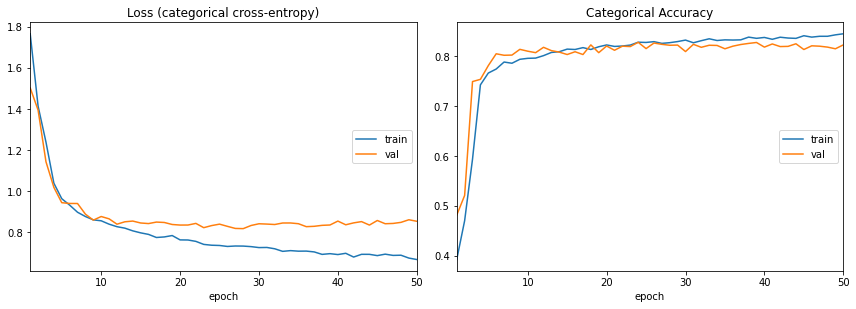

In [0]:
n_epochs = 50
batch_size = 64
callbacks = [
      tv.train.PlotMetricsOnEpoch(metrics_name=['Loss (categorical cross-entropy)', 'Categorical Accuracy'], 
                                  cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
 ]

hist3 = model3.fit(xtrain, ytrain, epochs=n_epochs, validation_data=(xtest, ytest), verbose=1, callbacks=callbacks, batch_size=batch_size)

There is less overfitting than in previous CNN model and maximum categorical accuracy is better.

### Sol 3 - Test the CNN classifier

In [0]:
ytest_est = model3.predict(xtest)

#### Top accuracies

In [0]:
ytest_accuracy_top, ytest_est_top = [], []
for i in range(1, topn+1):
  est_top = np.argpartition(ytest_est, -i, axis=1)[:, -i:]
  ytest_est_top.append(est_top)
  perf = ytest[range(len(ytest)), est_top.T].T.sum(axis=1) / np.minimum(np.ones(len(ytest)) * i, ytest.sum(axis=1))
  ytest_accuracy_top.append(perf)
  perf_summary = perf_summary.append({'model': 'model3', 'metric': 'top%d'% i, 'value': perf.mean()}, ignore_index=True)

perf_summary.loc[perf_summary.model == 'model3', ['metric', 'value']].set_index('metric')

,value
metric,
top1,0.871519
top2,0.938359
top3,0.976235


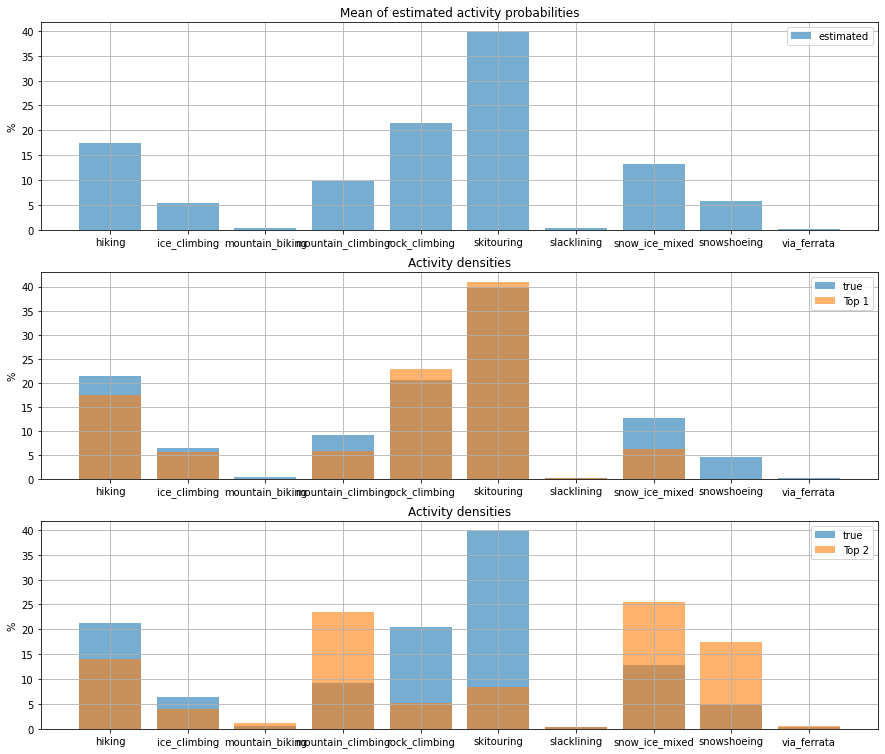

In [0]:
fig, axes = plt.subplots(3, 1, figsize=(15, 13))
ax = axes[0]
ax.bar(activity_labels, ytest_est.mean(axis=0) * 100, label='estimated', alpha=0.6)
ax.set_title('Mean of estimated activity probabilities')
ax.set_ylabel('%')
ax.legend()
ax.grid()
ax = axes[1]
ax.bar(activity_labels, ytest.mean(axis=0) * 100, label='true', alpha=0.6)
ax.bar(activity_labels, np.array([(ytest_est_top[0][:,0] == i).sum() for i in range(10)])/ len(ytest) * 100, label='Top 1', alpha=0.6)
ax.set_title('Activity densities')
ax.set_ylabel('%')
ax.legend()
ax.grid()
ax = axes[2]
ax.bar(activity_labels, ytest.mean(axis=0) * 100, label='true', alpha=0.6)
ax.bar(activity_labels, np.array([(ytest_est_top[1][:,0] == i).sum() for i in range(10)])/ len(ytest) * 100, label='Top 2', alpha=0.6)
ax.set_title('Activity densities')
ax.set_ylabel('%')
ax.legend()
ax.grid()

The class with the largest frequency (ski-touring) is taking most of the predicted probabilities at top-1 rank.

Hiking ("randonnée" in French) and shoeshowing are probably shadowed by ski-touring ("ski randonnée").

Same for mountain-climbing which is very close to climbing.

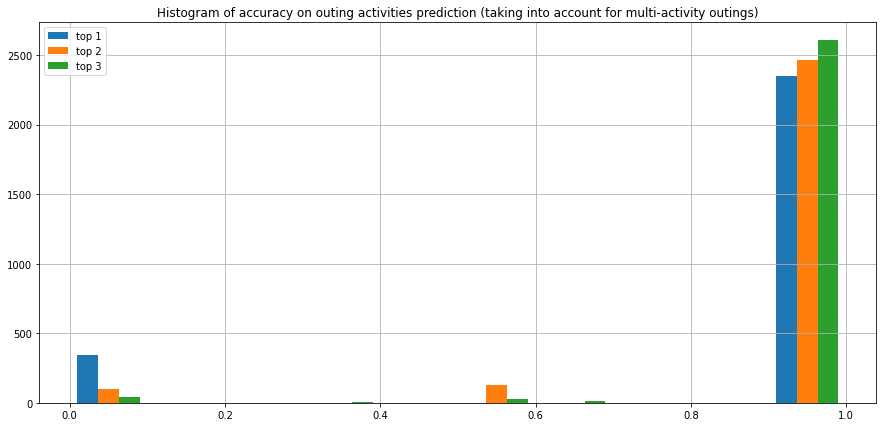

In [0]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(ytest_accuracy_top, density=False, label=['top %d' % i for i in range(1, topn+1)])
ax.legend()
ax.set_title('Histogram of accuracy on outing activities prediction (taking into account for multi-activity outings)')
ax.grid()

## Solution 4: embeddings computed within the CNN

### Sol 4 - Prepare data (scaling and split)

In [0]:
seq_max_length = 800 # Max number of words per sequence
embedding_dim  = 50  # Embedding dimension using the language model

Keras provides a tokenizer utility to prepare the sequences (series of integers) corresponding to the vocabulary (bag of words).

In [0]:
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*,./:;<=>?@[\\]^_`{|}~\t\n', # +-
    lower=True,
    split=" ",
    char_level=False)

tokenizer.fit_on_texts(routes['description_fr'])
vocabulary_length = len(tokenizer.word_counts) + 1

print("Size of vocabulary: %d" % vocabulary_length)

# Take first part of the description to display as hover label with embeddings
xall_abstract = routes['description_fr'].str.slice(0, 200)

xall = tokenizer.texts_to_sequences(routes['description_fr'])
xall = keras.preprocessing.sequence.pad_sequences(xall, maxlen=seq_max_length, padding='post')
xall.shape

Size of vocabulary: 45334


(13464, 800)

In [0]:
xtrain, xtest, ytrain, ytest, xtrain_abstract, xtest_abstract = model_selection.train_test_split(xall, yall, xall_abstract, test_size=0.2)
xtrain.shape, ytrain.shape

((10771, 800), (10771, 10))

### Sol 4 - Classifier instance and training

In [0]:
model4 = keras.models.Sequential([
    keras.layers.Embedding(vocabulary_length, embedding_dim, input_length=1, 
                           embeddings_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dropout(0.1),
    keras.layers.Reshape((seq_max_length, embedding_dim, 1)),
    keras.layers.Convolution2D(8, kernel_size=(32, 32), activation='relu', strides=(4, 2), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Convolution2D(8, kernel_size=(8, 8), activation='relu', strides=(2, 2), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Convolution2D(16, kernel_size=(4, 4), activation='relu', strides=(4, 2), padding='same'), 
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(yall.shape[1], activation='sigmoid')
], name='model4')

model4.compile(optimizer=keras.optimizers.Adam(), #learning_rate=0.001), 
               loss=keras.losses.CategoricalCrossentropy(from_logits=False), 
               metrics=[keras.metrics.CategoricalAccuracy()])

model4.summary()

Model: "model4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 50)             2266700   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 800, 50, 1)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 200, 25, 8)        8200      
_________________________________________________________________
dropout_17 (Dropout)         (None, 200, 25, 8)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 13, 8)        4104      
_________________________________________________________________
dropout_18 (Dropout)         (None, 100, 13, 8)        0    

Do not get confused by the high number of coefficients compared to previous DNN, the embedding coefficients are more of a large lookup table than a weight within a convolutional or a dense layer.

In [0]:
gc.collect()

109326

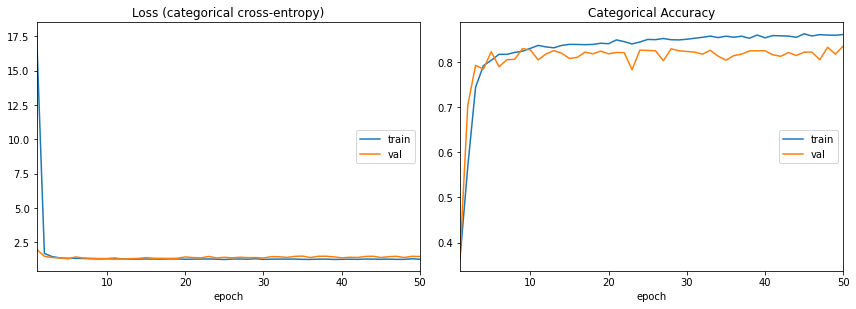

In [0]:
n_epochs = 50
batch_size = 64
callbacks = [
      tv.train.PlotMetricsOnEpoch(metrics_name=['Loss (categorical cross-entropy)', 'Categorical Accuracy'], 
                                  cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
 ]

hist4 = model4.fit(xtrain, ytrain, epochs=n_epochs, batch_size=batch_size, validation_data=(xtest, ytest), verbose=1, 
                   callbacks=callbacks)

Overfitting on the embedding layer is huge, requiring a strong regularization.

The performance is improving as the embeddings are tuned to the vocabulary and language structure.

### Sol 4 - Test the CNN classifier

In [0]:
ytest_est = model4.predict(xtest)

In [0]:
perf_summary = perf_summary[perf_summary.model != 'model4']
ytest_accuracy_top, ytest_est_top = [], []
for i in range(1, topn+1):
  est_top = np.argpartition(ytest_est, -i, axis=1)[:, -i:]
  ytest_est_top.append(est_top)
  perf = ytest[range(len(ytest)), est_top.T].T.sum(axis=1) / np.minimum(np.ones(len(ytest)) * i, ytest.sum(axis=1))
  ytest_accuracy_top.append(perf)
  perf_summary = perf_summary.append({'model': 'model4', 'metric': 'top%d'% i, 'value': perf.mean()}, ignore_index=True)
perf_summary.loc[perf_summary.model == 'model4', ['metric', 'value']].set_index('metric')

,value
metric,
top1,0.883030
top2,0.941515
top3,0.975863


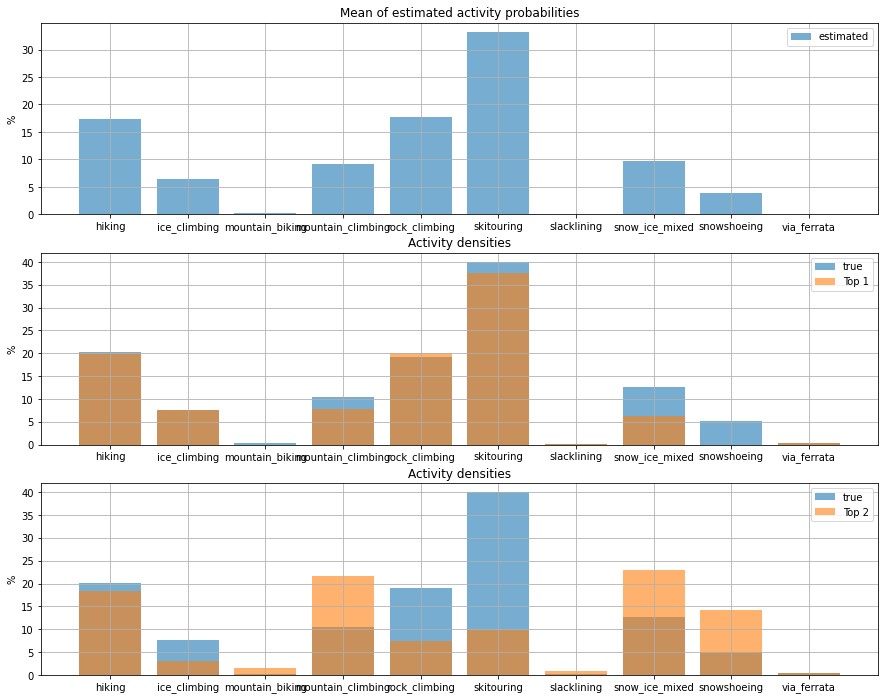

In [0]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
ax = axes[0]
ax.bar(activity_labels, ytest_est.mean(axis=0) * 100, label='estimated', alpha=0.6)
ax.set_title('Mean of estimated activity probabilities')
ax.set_ylabel('%')
ax.legend()
ax.grid()
ax = axes[1]
ax.bar(activity_labels, ytest.mean(axis=0) * 100, label='true', alpha=0.6)
ax.bar(activity_labels, np.array([(ytest_est_top[0][:,0] == i).sum() for i in range(10)])/ len(ytest) * 100, label='Top 1', alpha=0.6)
ax.set_title('Activity densities')
ax.set_ylabel('%')
ax.legend()
ax.grid()
ax = axes[2]
ax.bar(activity_labels, ytest.mean(axis=0) * 100, label='true', alpha=0.6)
ax.bar(activity_labels, np.array([(ytest_est_top[1][:,0] == i).sum() for i in range(10)])/ len(ytest) * 100, label='Top 2', alpha=0.6)
ax.set_title('Activity densities')
ax.set_ylabel('%')
ax.legend()
ax.grid()

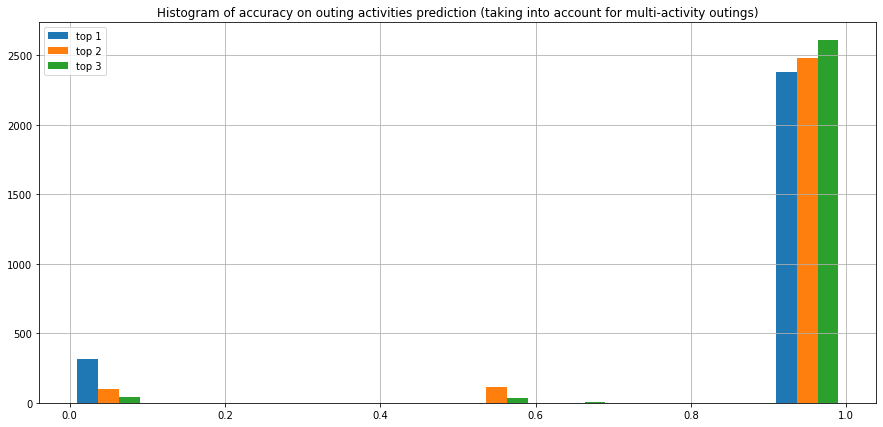

In [0]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(ytest_accuracy_top, density=False, label=['top %d' % i for i in range(1, topn+1)])
ax.legend()
ax.set_title('Histogram of accuracy on outing activities prediction (taking into account for multi-activity outings)')
ax.grid()

#### Apply embedding layer to mountain vocabulary

Let's compute the embeddings from the Keras trained layer for each words of the mountaineering handcrafted vocabulary

In [0]:
# Create a sequence for each word of the mountain vocabulary
xvoc = tokenizer.texts_to_sequences(voc_mountain2['word'])
xvoc = keras.preprocessing.sequence.pad_sequences(xvoc, maxlen=seq_max_length, padding='post')

# Compute embeddings on mountain vocabulary
model4_embed = keras.models.Model(inputs=model4.input, outputs=model4.layers[0].output)
voc_embeddings = model4_embed.predict(xvoc).squeeze()[:,0,:]

# Compute predictions on mountain vocabulary
voc_pred = model4.predict(xvoc)
voc_top1 = np.argmax(voc_pred, axis=1)

voc_embeddings.shape, voc_top1.shape

((132, 50), (132,))

UMAP is reducing the dimensions from 100 to 2

In [0]:
reducer = umap.UMAP()
reduced_embeddings = reducer.fit_transform(voc_embeddings);
reduced_embeddings.shape

(132, 2)

In [0]:
df = pd.DataFrame(np.c_[reduced_embeddings, 
                        act_label_array[voc_top1],
                        voc_mountain2['word']
                        ], columns=['x', 'y', 'estimated label', 'word'])

In [0]:
fig = px.scatter(df, x='x', y='y', color='estimated label', text='word',
                width=800, height=800)
fig.update_traces(textposition='top center', hovertext='ss')
fig.update_layout(title_text='Corpus specific Keras embeddings of the mountaineering vocabulary projected in 2D', width=1000, height=800)

While showing quite some structure, with some terms very close to each other, it is difficult to find some semantic explainations to these clusters. For example: pic (peak), cordelette (small rope), dry-tooling (some kind of rock climbing with axes) and ski-randonnée (ski touring).

On such small texts (1 word length), the estimates are quite meaningless, most of the predictions are related to rock climbing.

### Inspection of the failing top 1

The best algorithm are toping at ~ 89.5%. It could be a limit of the detectors but also an issue with data. Let's inspect the failing texts.

In [0]:
failing_idx = np.where(ytest_accuracy_top[0] < 1)[0]
failing = xtest[failing_idx]
failing_len = np.apply_along_axis(lambda row: len(np.where(row > 0)[0]), 1, failing)
failing.shape

(315, 800)

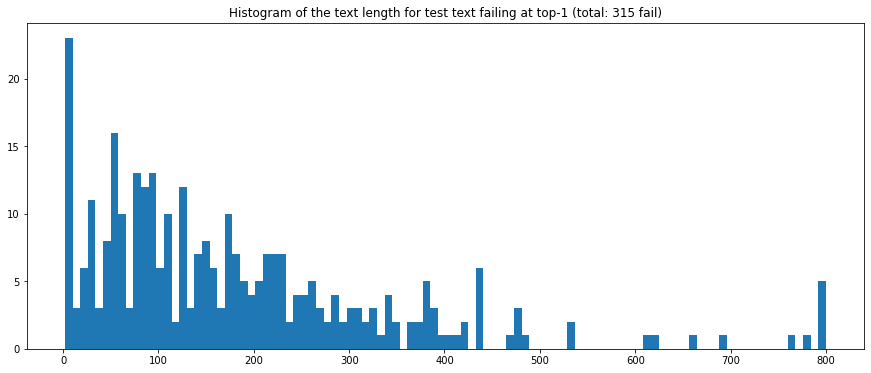

In [0]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(failing_len, bins=100, density=False);
ax.set_title('Histogram of the text length for test text failing at top-1 (total: %d fail)' % len(failing));

The shape of the histogram is similar to the one of the incoming sequences but with an extra spike around length of 180. However, the absolute values are small, beware of the statistical significance.

# 2D projection of estimates at last layer input

Last layer of the CNN is computing probabilities for each of the 10 target classes. Its input is 64 dimensions and is often the most interesting to project onto the 2D plan using t-SNE or UMAP. It is showing the capaticity of the neural network to simplify the high dimension manifold into a simpler problem on which a regression is applied within the last layer.


In [0]:
model4_preest = keras.models.Model(inputs=model4.input, outputs=model4.layers[-1].input)
ytest_preest = model4_preest.predict(xtest).squeeze()
ytest_preest.shape

(2693, 64)

In [0]:
reducer = umap.UMAP()
reduced_estimates = reducer.fit_transform(ytest_preest) # reducer.fit_transform(ytest_est);
reduced_estimates.shape

(2693, 2)

In [0]:
ytest_act_labels = pd.DataFrame(ytest).apply(lambda row: ", ".join(act_label_array.take(np.where(row == 1)[0])), axis=1)

In [0]:
df = pd.DataFrame(np.c_[reduced_estimates, 
                        act_label_array[np.argmax(ytest_est, axis=1)],
                        ytest_accuracy_top[0],
                        ytest_act_labels,
                        xtest_abstract,
                        ], columns=['x', 'y', 'estimated label', 'top-1 accuracy', 'activity labels', 'abstract'])

In [0]:
fig = px.scatter(df, x=df.x, y=df.y, color=df['estimated label'], opacity=0.5,
                 hover_name="estimated label", hover_data=['top-1 accuracy', 'activity labels', 'abstract'])
fig.update_traces(hovertemplate = "<b>%{hovertext}</b> <br />True labels: %{customdata[1]} <br />Abstract: \"%{customdata[2]}\"")
fig.update_layout(width=1000, height=800, 
                  title='Estimated probabilibities projected from 10D to 2D, colored with estimated mostlikely activity label')

On this graph is clearly shown the impact of the classifier in separating the different classes. It also showes that hiking, ski touring and rock climbing are quite diverse and spread.

Not so intuitive is the fact that mixed climbing is not close to ice climbing even if these two activities are quite close in gesture and context.

Some routes of mixed climbing and mountain climbing activities are close and sandwiched by ski-touring, hiking and rock climbing, which is corresponds to the reality as they require first to hike to the spot where the climb is performed.

In [0]:
fig = px.scatter(df, x=df.x, y=df.y, color=df['top-1 accuracy'], opacity=0.5,
                 hover_name="estimated label",
                 hover_data=['top-1 accuracy', 'activity labels', 'abstract'])
fig.update_traces(hovertemplate = "<b>%{hovertext}</b> <br />True labels: %{customdata[1]} <br />Abstract: \"%{customdata[2]}\"")
fig.update_layout(width=1000, height=800, 
                  title='Estimated probabilibities projected from 10D to 2D, colored with accuracy of the top-1 probability')

# Conclusion

Below is a summary of the performance for each of the four following models:
- model 1: fastText embeddings using pre-computed French model + CNN
- model 2: fastText classifier trained on the corpus
- model 3: fastText embeddings trained on the corpus + CNN
- model 4: CNN with embedding layer at input

Performance is very close between modek 2 and 4, difference lies within the margin of error linked to the weight initialization.

In [0]:
perf_summary.pivot(index='metric', columns='model')

value                              
model     model1    model2    model3    model4
metric                                        
top1    0.778314  0.911623  0.871519  0.883030
top2    0.898440  0.954697  0.938359  0.941515
top3    0.946095  0.978772  0.976235  0.975863

## References

1. [FastText library for efficient text classification and representation learning](https://fasttext.cc)
2. [Learning Word Vectors for 157 Languages, E. Grave, P. Bojanowski, P Gupta, A. Joulin, T. Mikolov, LREC 2018](https://arxiv.org/abs/1802.06893)
3. [Camp to Camp V6 API](https://github.com/c2corg/v6_api)
4. [Bag of tricks for efficient text classification](https://www.aclweb.org/anthology/E17-2068/)

To SORT:
- https://medium.com/@thoszymkowiak/how-to-implement-sentiment-analysis-using-word-embedding-and-convolutional-neural-networks-on-keras-163197aef623
- Very Deep Convolutional Networks for Natural Language Processing, Alexis Conneau, Holger Schwenk, Loïc Barrault, Yann Lecun, 2017, https://arxiv.org/abs/1606.01781v1, Character based embeddings, CNN